In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import Data_Process as dp
%load_ext autoreload
%autoreload 2


In [4]:
# Impute Missing Time Value
info = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("g-research-crypto-forecasting/train.csv")

btc = dp.c_time_sub(asset_id =1, data = ctrain)

In [5]:
#Box-Cox Transformation for monthly rolled
btc_month=btc.resample("M").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.865378


In [6]:
#Box-Cox Transformation for minute data
btc["close_box"], lmbda_2=stats.boxcox(btc.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])


Dickey–Fuller test: p=0.865378


In [67]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.064401


In [68]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.008042


Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
fot month value

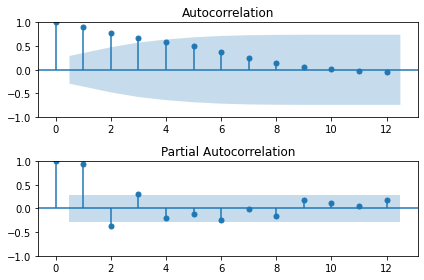

In [69]:
ax = plt.subplot(211)
# Plot the autocorrelation function
plot_acf(btc_month.Close.values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
plot_pacf(btc_month.Close.values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

We see that there are 4 spikes in the ACF, followed by an almost significant spike at lag 5.
In the PACF, there are 4 significant spikes, and then no significant spikes thereafter (apart from one just outside the bounds). We can ignore significant spikes in each plot if it is just outside the limits, and not in the first few lags

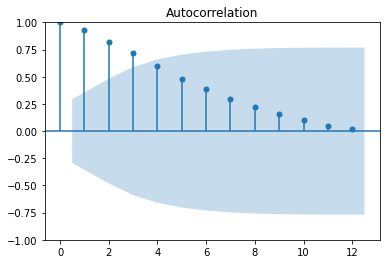

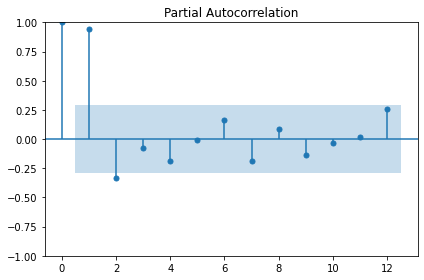

In [70]:
plot_acf(btc_month.close_box.values.squeeze(), lags=12)
plot_pacf(btc_month.close_box.values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

ARIMA for Close

In [71]:
PCT_VALIDATION = 0.1 # last 10% of the data are used as validation set

btc_month_train = btc_month[:int(len(btc_month)*(1-PCT_VALIDATION))]
btc_month_train.shape[0]/btc_month.shape[0]

0.8888888888888888

In [72]:
# Initial approximation of parameters

qs = range(0, 5)
ps = range(0, 5)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month_train.Close, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [73]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                   40
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -364.665
Date:                Sun, 02 Jan 2022   AIC                            733.331
Time:                        23:27:40   BIC                            736.658
Sample:                    01-31-2018   HQIC                           734.524
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5403      0.052     10.362      0.000       0.438       0.643
sigma2      7.393e+06   9.06e+05      8.159      0.000    5.62e+06    9.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                51.03
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                            -0.15
Prob(H) (two-sided):                  0.39   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters         aic
5      (1, 0)  733.330567
10     (2, 0)  734.679795
12     (2, 2)  734.687896
6      (1, 1)  734.909535
11     (2, 1)  735.871864


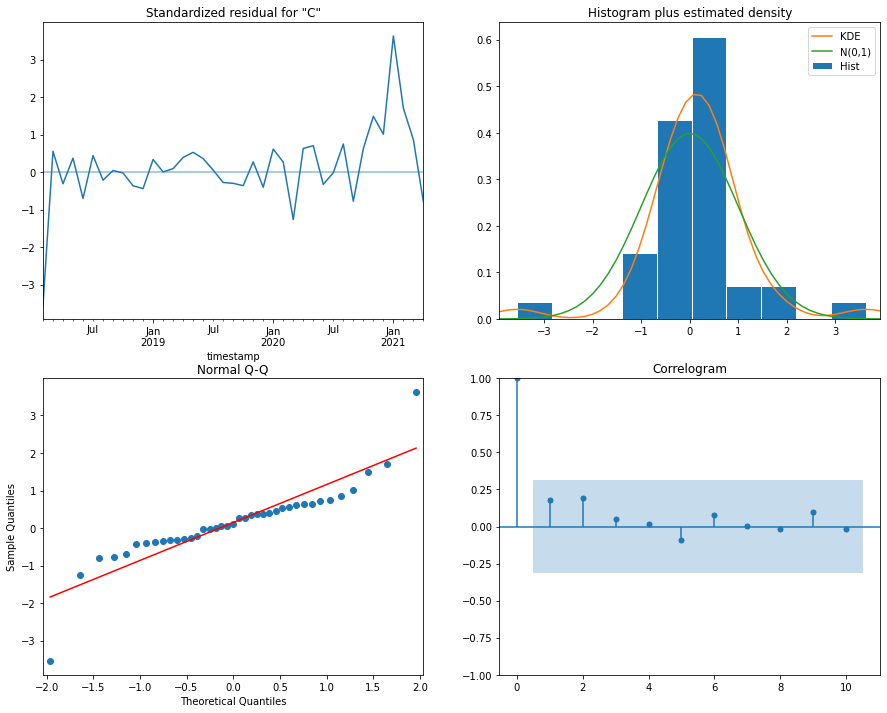

In [75]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [76]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.015737


<AxesSubplot:xlabel='timestamp'>

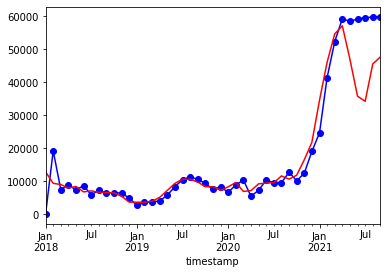

In [77]:
forecasts = best_model.predict(start = '2018-01-31',end = '2021-09-30') # predict N steps into the future

forecasts.plot(color='blue', label='Training Data',marker='o')
btc_month.Close.plot(color='red', label='Actual')

In [78]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [79]:
# Initial approximation of parameters

qs = range(0, 5)
ps = range(0, 5)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month_train.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [80]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters         aic
5      (1, 0) -391.386764
1      (0, 1) -390.510046
6      (1, 1) -389.479332
10     (2, 0) -389.475045
20     (4, 0) -387.972437


<AxesSubplot:xlabel='timestamp'>

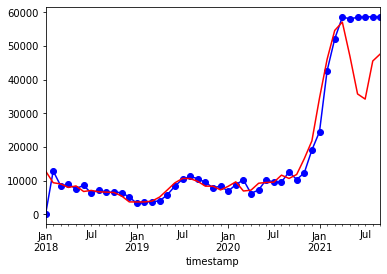

In [81]:
forecasts = invboxcox(best_model.predict(start = '2018-01-31',end = '2021-09-30'),lmbda) # predict N steps into the future

forecasts.plot(color='blue', label='Training Data',marker='o')
btc_month.Close.plot(color='red', label='Actual')

In [86]:
from pmdarima.model_selection import train_test_split

In [91]:
n_steps_to_train = 180*24*60 #0.5 year
btc_mini =  btc[-n_steps_to_train:]


btc_hour_mini = btc_mini.resample("H").mean()
train, test = train_test_split(btc_hour_mini.Close, train_size=int(btc_hour_mini.shape[0]*0.8))

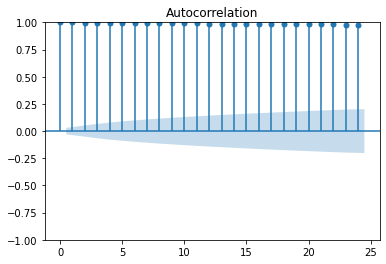

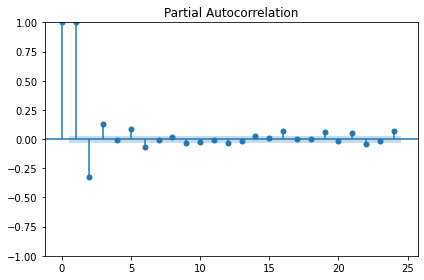

In [93]:
plot_acf(btc_hour_mini.Close.values.squeeze(), lags=24)
plot_pacf(btc_hour_mini.Close.values.squeeze(), lags=24)

plt.tight_layout()
plt.show()


In [114]:
# Fit your model
import pmdarima as pm
model = pm.auto_arima(train, seasonal=False)

# make your forecasts
forecasts,conf_int = model.predict(test.shape[0],return_conf_int=True)  # predict N steps into the future

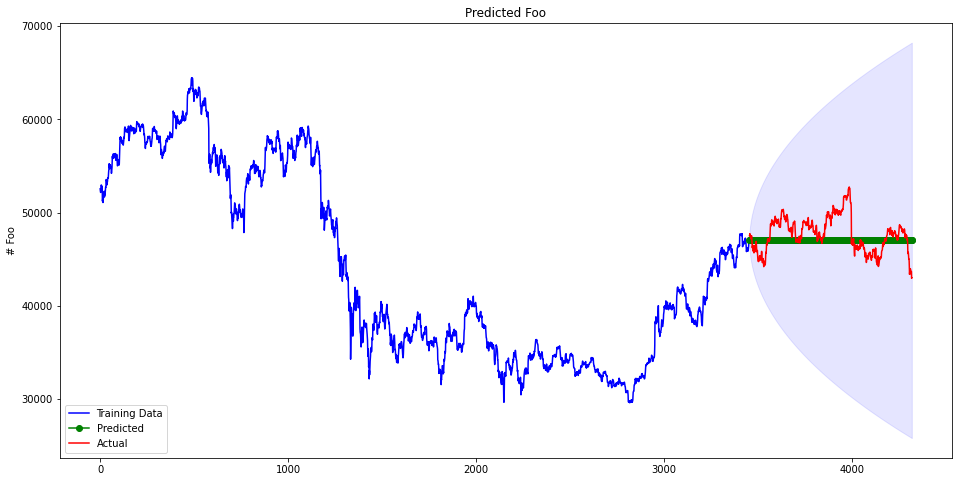

In [116]:
def plt_arima_result(y_train =train , forecasts = forecasts,y_test = test ):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)

    n_train = y_train.shape[0]
    x = np.arange(n_train + forecasts.shape[0])

    ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
    ax.plot(x[n_train:], forecasts, color='green', marker='o',
            label='Predicted')
    ax.plot(x[n_train:], y_test, color='red', label='Actual')
    ax.legend(loc='lower left', borderaxespad=0.5)
    ax.set_title('Predicted Foo')
    ax.set_ylabel('# Foo')
    plt.fill_between(x[n_train:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
    plt.show()
plt_arima_result()

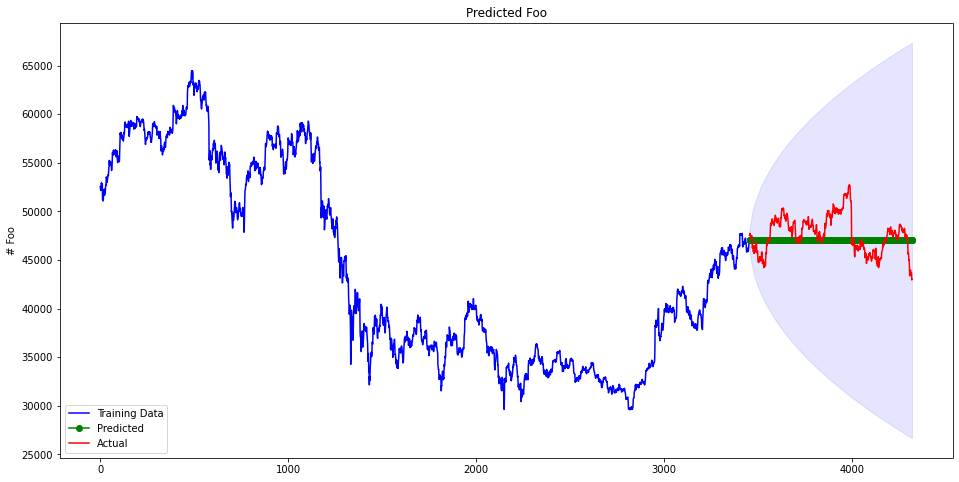

In [118]:
# Fit your model
import pmdarima as pm
model = pm.auto_arima(train, seasonal=True, m=24)

# make your forecasts
forecasts,conf_int = model.predict(test.shape[0],return_conf_int=True)  # predict N steps into the future
plt_arima_result()